# EES1133 Lab 5: Ice-albedo feedback in an EBM with `climlab`

Adapted from notes by:
[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

In this lab, we explore the ice-albedo feedback using a Budyko-Sellers type energy balance model (EBM). To do this we will use the EBM model in `climlab`. If you are interested in learning more about the details of the Budyko-Sellers model, see Section 10.4 of Hartmann.

____________
<a id='section1'></a>

## 1. The 1-Dimensional Energy Balance Model (EBM)
____________

As discussed briefly in class, the Budyko-Sellers model is an EBM that incorporates the ice-albedo feedback. The model is a function of time and **latitude**, so some sort of approximation of horizontal energy transport needs to be included. Here, we will assume a simple form of diffusive energy transport. 

This is the **first time** that we have used a model that has **latitude** as a dimension.

The equation for the one-dimensional EBM with diffusive heat transport looks like this:

$$ C \frac{\partial T}{\partial t} = (1-\alpha) ~ Q - \left( A + B~T \right) + \frac{D}{\cos\phi } \frac{\partial }{\partial \phi} \left(   \cos\phi  ~ \frac{\partial T}{\partial \phi} \right) $$


On the left-hand side (lhs) we have the energy storage term and on the right-hand side (rhs) we have three terms. The first is the ASR and the second term is the $OLR$, linearized as $OLR = A + BT$, where $T$ is the surface temperature (in $^{\circ}C$). It should look similar to the model we used in Lab 1, except with an extra term.

The third term on the rhs represents the diffusive horizontal heat transport, where $D$ is the thermal diffusivity. Diffusive, in this case, just means that heat diffuses down the temperature gradient, $\frac{\partial T}{\partial \phi}$, from warmer regions to colder regions, where $\phi$ is latitude. Note that the $cos\phi$'s appear because we are calculating gradients on a sphere.

Note, that we only have one layer in the vertical - the surface layer.

The following parameter values give a reasonable fit to the observed **annual mean surface temperature and energy budget**:

- $ A = 210 ~ \text{W m}^{-2}$ (emission at 0$^\circ$C)
- $ B = 2 ~ \text{W m}^{-2}~^\circ\text{C}^{-1} $ (increase in emission per degree, related to net longwave climate feedback)
- $ D = 0.55 ~ \text{W m}^{-2}~^\circ\text{C}^{-1} $ (thermal diffusivity of the climate system)

Since our model is 1-D in the horizontal direction, we cannot calculate OLR directly as we did in the column model. So, how did we come up with the above values for $A$ and $B$ in our $OLR$ expression?

We use linear regression!

We simply find the best-fit line between surface temperature and $OLR$ to find $A$, the intercept, and $B$ the slope. Let's see how this is done.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab

Let's load in some observational data from NCEP:

In [2]:
#  Load observational data
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = xr.open_dataset( ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc", decode_times=False)
lat_ncep = ncep_Ts.lat; lon_ncep = ncep_Ts.lon
print(ncep_Ts)

<xarray.Dataset>
Dimensions:             (lat: 94, lon: 192, nbnds: 2, time: 12)
Coordinates:
  * lon                 (lon) float32 0.0 1.875 3.75 ... 354.375 356.25 358.125
  * time                (time) float64 -6.571e+05 -6.57e+05 ... -6.567e+05
  * lat                 (lat) float32 88.542 86.6531 ... -86.6531 -88.542
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) float64 ...
    skt                 (time, lat, lon) float32 ...
    valid_yr_count      (time, lat, lon) float32 ...
Attributes:
    title:                          4x daily NMC reanalysis
    description:                    Data is from NMC initialized reanalysis\n...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    dataset_title:                  NCEP-NCAR Reanalysis 1
    Refe

In [3]:
#  Annual and zonal mean surface temperature
#  Note: 'skt' stands for skin temperature (essentially the surface temperature)
Ts_ncep_annual = ncep_Ts.skt.mean(dim=('lon','time')) 

In [4]:
#  Annual and zonal mean TOA radiative fluxes
#  Note: ulwrf = upward longwave radiative flux
#        dswrf = downward shortwave radiative flux
#        uswrf = upward shortwave radiative flux

ncep_ulwrf = xr.open_dataset( ncep_url + "other_gauss/ulwrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
ncep_dswrf = xr.open_dataset( ncep_url + "other_gauss/dswrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)
ncep_uswrf = xr.open_dataset( ncep_url + "other_gauss/uswrf.ntat.mon.1981-2010.ltm.nc", decode_times=False)

OLR_ncep_annual = ncep_ulwrf.ulwrf.mean(dim=('lon','time'))
ASR_ncep_annual = (ncep_dswrf.dswrf - ncep_uswrf.uswrf).mean(dim=('lon','time'))

In [5]:
#  Now let's fit our linear regression:
#  Uncomment and complete the lines below.

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(Ts_ncep_annual, OLR_ncep_annual)  #what is the predictor and what is the predictand?

print( 'Best fit is A = %0.0f W/m2 and B = %0.1f W/m2/degC' %(intercept, slope))

Best fit is A = 214 W/m2 and B = 1.6 W/m2/degC


You should get an intercept value of 214 W/m2 and a slope value of 1.6 W/m2/degC. 

We get slightly different values than the typical values that are used for this type of EBM are. We will stick with the default values for now:

In [6]:
A = 210 #  W/m2
B = 2   #  W/m2/degC

Let's plot the observed data and both best-fit lines and compare.

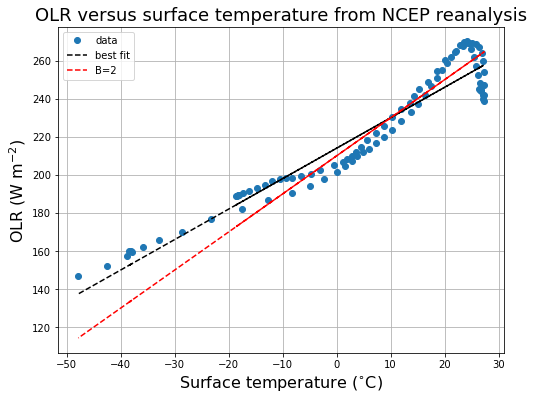

In [7]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot( Ts_ncep_annual, OLR_ncep_annual, 'o' , label='data')

#  Add the "best-fit" line and the line using the more typical values for A and B
ax1.plot(Ts_ncep_annual,214 + Ts_ncep_annual*1.6 , 'k--', label='best fit')
ax1.plot(Ts_ncep_annual,A + Ts_ncep_annual*B , 'r--', label='B=2')
ax1.set_xlabel('Surface temperature ($^{\circ}$C)', fontsize=16)
ax1.set_ylabel('OLR (W m$^{-2}$)', fontsize=16)
ax1.set_title('OLR versus surface temperature from NCEP reanalysis', fontsize=18)
ax1.legend(loc='upper left')
ax1.grid()

#save the figure
#plt.savefig()

Taking these reference values:

$$ A=210 ~\text{W m}^{−2}\\  B=2 ~\text{W m}^{−2}~^\circ\text{C}^{-1} $$

and our globally-average surface temperature, $T_s =288 K=15~^\circ\text{C}$,

this parameterization gives,

In [8]:
OLR = 15*2 + 210
print(OLR)

240


Recall that the observed global mean is $OLR = 239 ~\text{W m}^{−2}$. Do we get a consistent value?

____________
<a id='section2'></a>

## 2. Interactive snow/ice line in the EBM
____________

What we want to do in this lab is introduce another process into this 1-D EBM: an **interactive snow and ice line**. 

The idea is simply that, as the climate gets warmer, the snow and ice will retreat poleward, and the planetary albedo will decrease (or vice-versa).

Here, since our model resolves temperature at each latitude, we can do something reasonably physical: *suppose that the surface is covered in ice and snow wherever the temperature is below some threshold $T_f$.*

### Temperature-dependent ice line

Let the surface albedo be larger wherever the temperature is below some threshold $T_f$:

$$ \alpha\left(\phi, T(\phi) \right) = \left\{\begin{array}{ccc} 
\alpha_0 + \alpha_2 P_2(\sin\phi) & ~ & T(\phi) > T_f  & \text{(no ice)} \\
\alpha_i & ~ & T(\phi) \le T_f & \text{(ice-covered)} \\
\end{array} \right. $$

where $P_2(\sin\phi) = \frac{1}{2}\left( 3\left(\sin\phi\right)^2 - 1 \right) $ is called the *second Legendre Polynomial* (just a mathematically convenient description of a smooth variation between the equator and pole) and $\alpha_i$ is the albedo of ice.

**Reflection Question:**\
What does $\alpha_2$ represent?

Empirically, we follow classic work by Budyko and set the threshold temperature

$$ T_f = -10^\circ\text{C} $$

This is known as a "step function" formula, because the value of $\alpha$ steps or jumps up to a higher value as we cross the ice line.

____________
<a id='section3'></a>

## 3. Solving the EBM with variable snow/ice line in `climlab`
____________

In [9]:
from climlab import constants as const

In [10]:
#  for convenience, set up a dictionary with our reference parameters. Note that ai > ao.
param = {'D':0.55, 'A':210, 'B':2, 'a0':0.3, 'a2':0.078, 'ai':0.62, 'Tf':-10.}

In [11]:
#  A python shortcut... we can use the dictionary to pass lots of input arguments simultaneously:

# initialize and EBM with horizontal transport:
model1 = climlab.EBM_annual( num_lat=180, **param)
print(model1)

climlab Process of type <class 'climlab.model.ebm.EBM_annual'>. 
State variables and domain shapes: 
  Ts: (180, 1) 
The subprocess tree: 
Untitled: <class 'climlab.model.ebm.EBM_annual'>
   LW: <class 'climlab.radiation.aplusbt.AplusBT'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>
   albedo: <class 'climlab.surface.albedo.StepFunctionAlbedo'>
      iceline: <class 'climlab.surface.albedo.Iceline'>
      warm_albedo: <class 'climlab.surface.albedo.P2Albedo'>
      cold_albedo: <class 'climlab.surface.albedo.ConstantAlbedo'>
   SW: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>
   diffusion: <class 'climlab.dynamics.meridional_heat_diffusion.MeridionalHeatDiffusion'>



Because we provided a parameter `ai` for the icy albedo, our model now contains several sub-processes contained within the process called `albedo`. Together these implement the step-function formula above.

The process called `iceline` simply looks for grid cells with temperature below $T_f$.

In [17]:
#  Here are all the parameters
print(model1.param)

{'timestep': 350632.51200000005, 'S0': 1365.2, 's2': -0.48, 'A': 210, 'B': 2, 'D': 0.55, 'Tf': -10.0, 'water_depth': 10.0, 'a0': 0.3, 'a2': 0.078, 'ai': 0.62}


Now, let's integrate our EBM out to equilibrium

In [19]:
model1.integrate_years(5)

Integrating for 450 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 5.000000000000044 years.


Diagnostics in this model are mostly on the latitude axis, e.g.:

In [21]:
#  There is a value of ASR for each latitude.
#  We can see this by printing our value of ASR for each latitude

for i in range(len(model1.lat)):
    #  print out each latitude and each value of ASR using slicing
    print(model1.lat[i],model1.ASR[i])  #complete this print command

-89.5 [65.71797533]
-88.5 [65.76244815]
-87.5 [65.84761904]
-86.5 [65.97923937]
-85.5 [66.15142104]
-84.5 [66.36917776]
-83.5 [66.63263704]
-82.5 [66.93823592]
-81.5 [67.2910667]
-80.5 [67.69112601]
-79.5 [68.13642192]
-78.5 [68.63061992]
-77.5 [69.17502064]
-76.5 [69.76984994]
-75.5 [70.41686003]
-74.5 [71.11806553]
-73.5 [71.8766754]
-72.5 [72.69521702]
-71.5 [73.57685571]
-70.5 [74.52622406]
-69.5 [126.5151735]
-68.5 [128.64225662]
-67.5 [130.94704321]
-66.5 [133.4799311]
-65.5 [136.31700247]
-64.5 [139.35073236]
-63.5 [142.52593606]
-62.5 [145.81221046]
-61.5 [149.18851573]
-60.5 [152.63894184]
-59.5 [156.15081983]
-58.5 [159.71369723]
-57.5 [163.31871561]
-56.5 [166.9582033]
-55.5 [170.62539457]
-54.5 [174.3142284]
-53.5 [178.01919988]
-52.5 [181.73524799]
-51.5 [185.45766933]
-50.5 [189.1820507]
-49.5 [192.90421597]
-48.5 [196.62018373]
-47.5 [200.32613334]
-46.5 [204.01837763]
-45.5 [207.69334083]
-44.5 [211.3475408]
-43.5 [214.97757473]
-42.5 [218.58010762]
-41.5 [222.15186324]

Now, let's see what the albedo looks like (recall the step-function equation for the albedo above)

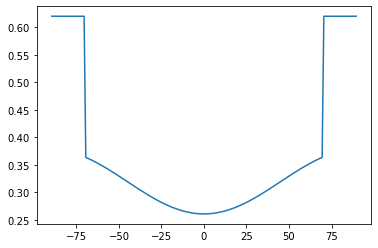

In [23]:
#  Plot the albedo as a function of latitude. The name of the albedo variable is simply, albedo.
#  Be sure that this plot and how it corresponds to the equation make sense to you.
#  Complete the line below

plt.plot(model1.lat,model1.albedo)

Now, let's check the energy balance. Since we have moved beyond a simple column model, we need to check that the globally-averaged ASR balances the globally-averaged OLR.

There is a built-in utility to take properly area-weighted global averages!

This gives us the net global energy imbalance:

In [24]:
climlab.global_mean(model1.ASR - model1.OLR)

array(0.02589604)

There is also a built-in diagnostic `net_radiation` that has the same information (i.e. ASR - OLR):

In [25]:
climlab.global_mean(model1.net_radiation)

array(0.02589604)

Since it's not quite fully equilibrated yet, we can run it out a little longer:

In [26]:
# Integrate out to equilibrium.
model1.integrate_years(5)

# Check for energy balance
print(climlab.global_mean(model1.net_radiation))

Integrating for 450 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 9.999999999999863 years.
1.2815863643387452e-05


**Reflection Question:** Why do we have to take the global average to assess energy balance? Keep this question in mind as you look at the plots below.

Now, let's make some plots to see what the climate of this model looks like. Below is a plotting function that we will use througout.

In [27]:
#  Here, we are just defining a plotting function that we will use throughout. 
#  Be sure you understand what this code is doing

def ebm_plot(e,return_fig=False):  #where e is the name of the EBM, e.g. model1  
    templimits = -60,32
    radlimits = -340, 340
    htlimits = -6,6
    latlimits = -90,90
    lat_ticks = np.arange(-90,90,30)
    
    fig = plt.figure(figsize=(8,12))

    # plot Ts as a function of latitude
    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(e.lat, e.Ts)
    ax1.set_ylim(templimits)
    ax1.set_ylabel('Temperature (deg C)')
    
    # plot ASR, OLR, net Radiation, heat transport convergence
    #  and the sum of net radiation and heat transport convergence as a function of latitude
    ax2 = fig.add_subplot(3,1,2)
    ax2.plot(e.lat, e.ASR, 'k--', label='SW' )
    ax2.plot(e.lat, -e.OLR, 'r--', label='LW' )
    ax2.plot(e.lat, e.net_radiation, 'c-', label='net rad' )
    ax2.plot(e.lat, e.heat_transport_convergence, 'g--', label='heat transport' )
    ax2.plot(e.lat, e.net_radiation.squeeze() + e.heat_transport_convergence.squeeze(), 'b-', label='total' )
    ax2.set_ylim(radlimits)
    ax2.set_ylabel('Energy budget (W m$^{-2}$)')
    ax2.legend()
    
    # plot heat transport as a function of latitude
    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(e.lat_bounds, e.heat_transport )
    ax3.set_ylim(htlimits)
    ax3.set_ylabel('Heat transport (PW)')
    
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('Latitude')
        ax.set_xlim(latlimits)
        ax.set_xticks(lat_ticks)
        ax.grid()
    
    if return_fig:
        return fig

Let's try the function.

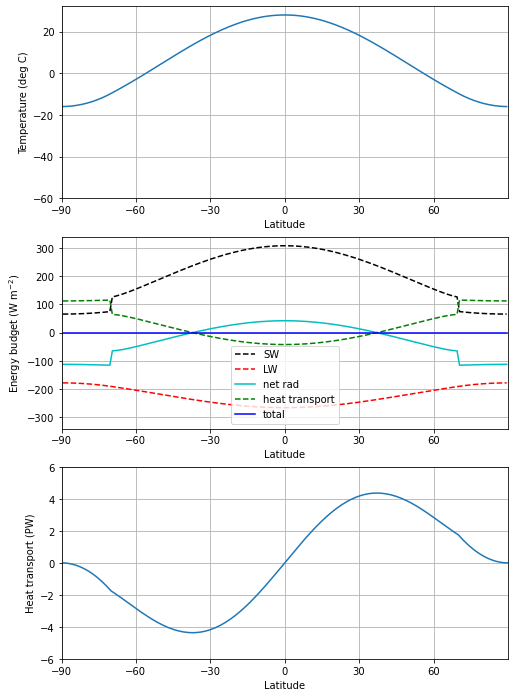

In [28]:
#  Now, let's plot the output using the plotting function defined above
#  Note that our plots have latitude on the x-axis
f = ebm_plot(model1)

**Reflection Question:**\
What do you see in this plot? Recall from Lecture 3 that the net radiative flux at the TOA must be balanced by the heat transport convergence at each latitude. 

Since the albedo of ice is an important component of this model, let's check the latitude of the ice line.

In [29]:
#  There is a diagnostic that tells us the current location of the ice edge:
print(model1.icelat)

[-70.  70.]


This model is tuned up to reasonable "present-day" conditions.

____________
<a id='section4'></a>

## 4. Warming in the EBM
____________

### Add a small radiative forcing

The equivalent of doubling CO2 in this model is something like 

$$ A \rightarrow A - \delta A $$

where $\delta A = 4$ W m$^{-2}$.



Why is $\delta A$ negative? Be sure you understand why in terms of how CO2 affects OLR.

In [31]:
model1.subprocess['LW'].A

210

Let's define a new model with this altered value of A.

In [32]:
deltaA = 4.

#  This is a very handy way to "clone" an existing model:
model2 = climlab.process_like(model1)

#  Now change the longwave parameter:
model2.subprocess['LW'].A = param['A'] - deltaA

In [33]:
#  integrate out to equilibrium again
model2.integrate_years(5, verbose=False)

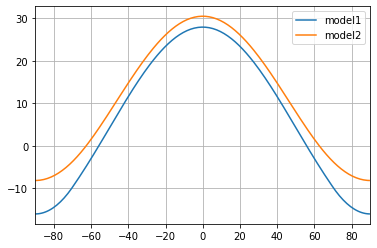

In [38]:
#  Compare the surface temperature (as a function of latitude for model1 and model2)
#  Complete and uncomment the lines below.

plt.plot(model1.lat,model1.Ts, label='model1')
plt.plot(model2.lat,model2.Ts, label='model2')
plt.xlim(-90, 90)
plt.legend()
plt.grid()

What differences do you see in the temperature structure?

Is the warming equal at all latitdues? Why or why not?

Also, the current ice line is now:

In [39]:
#  print the ice latitudes

print(model2.icelat)

[-90.  90.]


What happened to the ice?

Let's do some more greenhouse warming:

In [40]:
model3 = climlab.process_like(model1)

#  Add double deltaA this time.
model3.subprocess['LW'].A = param['A'] - 2*deltaA

#  Integrate to equilibrium
model3.integrate_years(5, verbose=False)

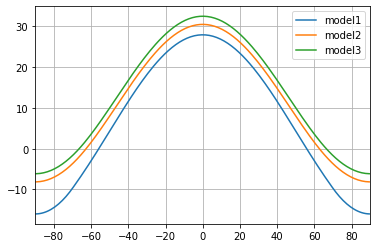

In [41]:
#  Compare the surface temperature (as a function of latitude for model1, model2 and model3)
#  Complete and uncomment lines below.

plt.plot(model1.lat,model1.Ts, label='model1')
plt.plot(model2.lat,model2.Ts, label='model2')
plt.plot(model3.lat,model3.Ts, label='model3')
plt.xlim(-90, 90)
plt.grid()
plt.legend()

What happens to the temperature structure this time? Is the warming equal at all latitdues? Why or why not?

____________
<a id='section5'></a>

## 5. A different kind of climate forcing: changing the solar constant
____________

Historically, EBMs have been used to study the climatic response to a change in the energy output from the Sun.

We can do that easily with `climlab`:

In [51]:
#  Let's define a new model with the same parameters are before
m = climlab.EBM_annual( num_lat=180, **param )

Let's see what the default solar constant is for this model.

In [52]:
#  The current (default) solar constant, corresponding to present-day conditions:
m.subprocess.insolation.S0

1365.2

Let's integrate the model to equilibrium.

In [53]:
#  First, get to equilibrium
m.integrate_years(10.)
#  Check for energy balance
climlab.global_mean(m.net_radiation)

Integrating for 900 steps, 3652.4220000000005 days, or 10.0 years.
Total elapsed time is 9.999999999999863 years.


array(1.28158636e-05)

In [54]:
m.icelat

array([-70.,  70.])

###  What happens if we decrease $S_0$?

We can change the solar constant in our model to see how the model behaves.

In [55]:
#  Now make the solar constant smaller (1300 W/m2):
m.subprocess.insolation.S0 = 1300.0

In [56]:
#  Integrate to new equilibrium
m.integrate_years(10.)

#  Check for energy balance
climlab.global_mean(m.net_radiation)

Integrating for 900 steps, 3652.4220000000005 days, or 10.0 years.
Total elapsed time is 19.99999999999943 years.


array(-0.00013409)

Let's see if our ice line changed when we decreses the radiation from the Sun.

In [58]:
#  where is the ice line?
print(m.icelat)

[-54.  54.]


We can use the plotting function to look at how other variables in the model climate have changed.

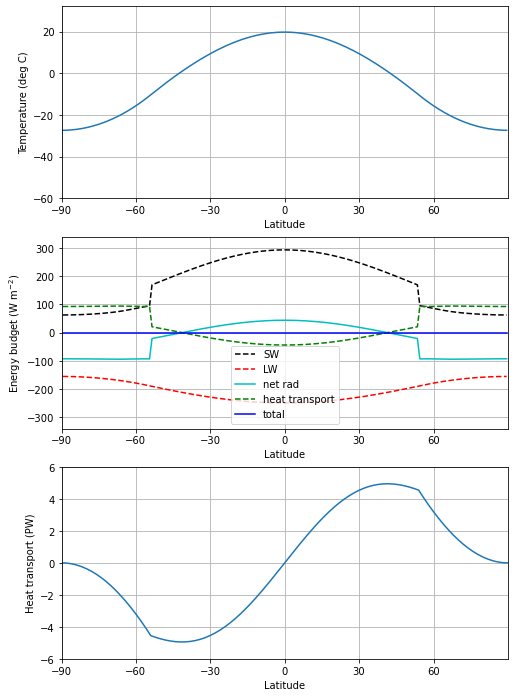

In [59]:
# plot using ebm_plot()
ebm_plot(m)

We get a much colder climate! The heat transport shows that the atmosphere is moving lots of energy across the ice line, trying hard to compensate for the strong radiative cooling everywhere poleward of the ice line. 

Compare with the earlier figures of the energy balance and heat transport that we created above.

____________
<a id='section6'></a>

## 6. The large ice cap instability
____________

###  What happens if we decrease $S_0$ even more?

This simple EBM has a unique characteristic, which we will now explore by decreasing the solar constant even more and then increasing it again.

In [61]:
#  Now make the solar constant smaller (1200 W/m2):
m.subprocess.insolation.S0 = 1200.0

#  First, get to equilibrium
m.integrate_years(5.)

#  Check for energy balance
climlab.global_mean(m.net_radiation)

Integrating for 900 steps, 3652.4220000000005 days, or 10.0 years.
Total elapsed time is 35.0000000000016 years.


array(-1.25838355e-06)

In [45]:
#  We need to integrate more...
m.integrate_years(10.)
#  Check for energy balance
climlab.global_mean(m.net_radiation)

Integrating for 900 steps, 3652.4220000000005 days, or 10.0 years.
Total elapsed time is 30.000000000000693 years.


array(-1.25838487e-06)

Plot the model variables using `ebm_plot()`.

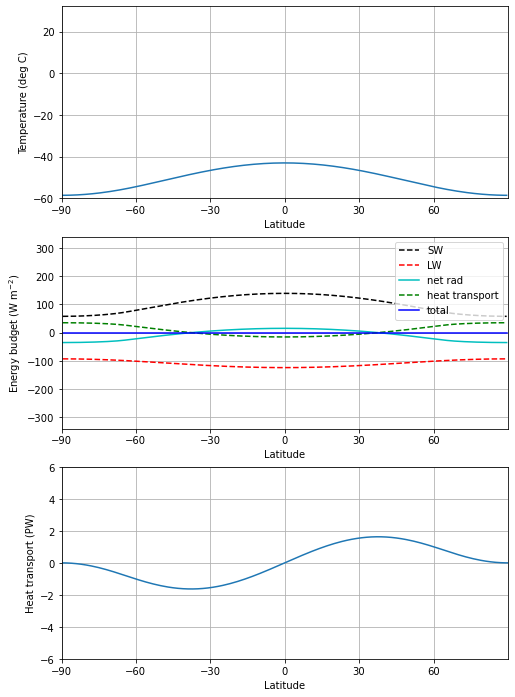

In [62]:
ebm_plot(m)

Something very different happened! Where is the ice line now?

In [63]:
#  print out the ice line latitudes
print(m.icelat)

[-0.  0.]


What has happened to the ice in this model?

### Now what happens if we set $S_0$ back to its present-day value?

In [64]:
#  Now make the solar constant present-day value again:
m.subprocess.insolation.S0 = 1365.2

#  First, get to equilibrium
m.integrate_years(5.)

#  Check for energy balance
climlab.global_mean(m.net_radiation)

Integrating for 450 steps, 1826.2110000000002 days, or 5.0 years.
Total elapsed time is 40.0000000000025 years.


array(0.00790051)

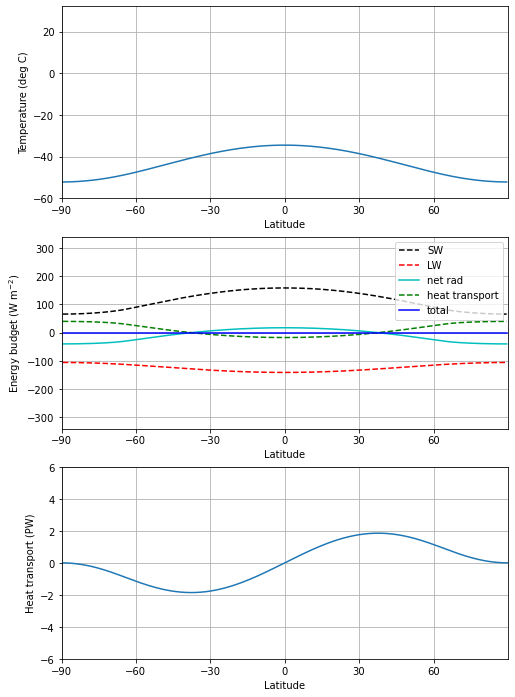

In [65]:
ebm_plot(m)

Is this the same climate we started with? Where is the ice line?

In [66]:
# print the ice line latitudes
print(m.icelat)

[-0.  0.]


The ice line hasn't moved even though we changed the solar constant back to its present day value. This is an example of a **hysteresis** in the climate system: the state of the climate depends on its history!

Here's a possible scenario for what happened to our model climate:

- A global cooling caused snow and ice to expand to the equator
- External conditions (i.e. the solar constant) returned back to its present-day value
- The climate stayed cold and completely ice-covered.

This model suggests that if the oceans froze over and the Earth were covered in ice and snow today, it would remain that way!

____________
<a id='section7'></a>

## 7. The Neoproterozoic Snowball Earth
____________

###  The Snowball Earth hypothesis

Various bizarre features in the geological record from 635 and 715 Ma ago indicate that the Earth underwent some very extreme environmental changes at least twice. The **Snowball Earth hypothesis** postulates that:

- The Earth was completely ice-covered (including the oceans)
- The total glaciation endured for millions of years
- CO$_2$ slowly accumulated in the atmosphere from volcanoes
- Weathering of rocks (normally acting to reduce CO$_2$) extremely slow due to cold, dry climate
- Eventually the extreme greenhouse effect is enough to melt back the ice
- The Earth then enters a period of extremely hot climate.

The hypothesis rests on a phenomenon first discovered by climate modelers in the Budyko-Sellers EBM: **runaway ice-albedo feedback** or **large ice cap instability**.

____________
<a id='section8'></a>

## 8. Computing the complete hysteresis curve for the 1D diffusive EBM
____________

<div class="alert alert-warning">
The calculations in this section may take a long time to complete, depending on the speed of your computer.
</div>

The ice edge in our model is always where the temperature crosses $T_f = -10^\circ$C. The system is at **equilibrium** when the temperature is such that there is a balance between ASR, OLR, and heat transport convergence everywhere. 

Suppose that the sun was hotter or cooler at different times (in fact it was significantly cooler during early Earth history). That would mean that the solar constant $S_0 = 4Q$ was larger or smaller. We should expect that the temperature (and thus the ice edge) should increase and decrease as we change $S_0$. 

$S_0$ during the Neoproterozoic Snowball Earth events is believed to be about 93% of its present-day value, or about 1270 W m$^{-2}$.

We are going to look at how the **equilibrium** ice edge depends on $S_0$, by integrating the model out to equilibrium for lots of different values of $S_0$. We will start by slowly decreasing $S_0$, and then slowly increasing $S_0$.

In [75]:
# Define a new model and integrate to equilibrium
m2 = climlab.EBM_annual(num_lat = 360, **param)
m2.integrate_years(5)

Integrating for 450 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 5.000000000000044 years.


In [76]:
# complete the line below by defining an array of 200 So values from 1400 to 1200 W/m2
S0array = np.linspace(1400,1200,50)

# initialize arrays to save the ice line latitude (we will just save the latitude of the Northern Hemisphere)
icelat_cooling = np.empty_like(S0array)
icelat_warming = np.empty_like(S0array)

*Note: This is the slowest step*

In [77]:
# First cool....
# loop over the array of So values
for n in range(S0array.size):
    m2.subprocess['insolation'].S0 = S0array[n]
    m2.integrate_years(10, verbose=False)
    icelat_cooling[n] = np.max(m2.icelat)
    
# Then warm...
# loop over the array of So values in reverse (np.flipud)
for n in range(S0array.size):
    m2.subprocess['insolation'].S0 = np.flipud(S0array)[n]
    m2.integrate_years(10, verbose=False)
    icelat_warming[n] = np.max(m2.icelat)
    
# For completeness -- also start from present-day conditions and warm up.
m3 = climlab.EBM_annual(num_lat=360, **param)
S0array3 = np.linspace(1350., 1400., 20)
icelat3 = np.empty_like(S0array3)
for n in range(S0array3.size):
    m3.subprocess['insolation'].S0 = S0array3[n]
    m3.integrate_years(10, verbose=False)
    icelat3[n] = np.max(m3.icelat)

Now, let's plot the ice line latitude as a function of $S_o$ to get a sense of the behaviour of this model.

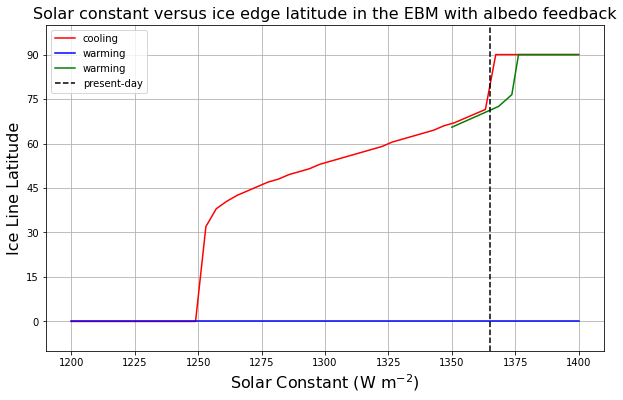

In [78]:
# plot the hysteresis: plot ice line latitdue as a function of So
fig = plt.figure( figsize=(10,6) )
ax = fig.add_subplot(111)
ax.plot(S0array, icelat_cooling, 'r-', label='cooling' )
ax.plot(S0array, icelat_warming, 'b-', label='warming' )
ax.plot(S0array3, icelat3, 'g-', label='warming' )
ax.set_ylim(-10,100)
ax.set_yticks((0,15,30,45,60,75,90))
ax.grid()
ax.set_ylabel('Ice Line Latitude', fontsize=16)
ax.set_xlabel('Solar Constant (W m$^{-2}$)', fontsize=16)
ax.plot( [const.S0, const.S0], [-10, 100], 'k--', label='present-day' )
ax.legend(loc='upper left')
ax.set_title('Solar constant versus ice edge latitude in the EBM with albedo feedback', fontsize=16);

There are actually up to 3 different climates possible for a given value of $S_0$!

### How to un-freeze the Snowball

The graph indicates that if the Earth were completely frozen over, it would be perfectly happy to stay that way even if the sun were brighter and hotter than it is today.

Our EBM predicts that (with present-day parameters) the equilibrium temperature at the equator in the Snowball state is about -33ºC, which is much colder than the threshold temperature $T_f = -10^\circ$C. How can we melt the Snowball?

We need to increase the avaible energy sufficiently to get the equatorial temperatures above this threshold! That is going to require a much larger increase in $S_0$ (could also increase the greenhouse gases, which would have a similar effect)!

**Let's crank up the sun to 1830 W m$^{-2}$** (about a 35% increase from present-day).

In [79]:
my_ticks = [-90,-60,-30,0,30,60,90]

m4 = climlab.process_like(m2)  # initialize with cold Snowball temperature
m4.subprocess['insolation'].S0 = 1830.0
m4.integrate_years(40)

Integrating for 3600 steps, 14609.688000000002 days, or 40 years.
Total elapsed time is 1045.000000000071 years.


What does the surface temperature look like?

([<matplotlib.axis.XTick at 0x7f9279e40f70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

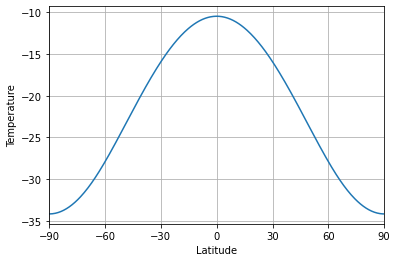

In [80]:
#Plot surface temperature as a function of latitude
plt.plot(m4.lat,m4.Ts)
plt.xlim(-90,90); plt.ylabel('Temperature'); plt.xlabel('Latitude')
plt.grid(); plt.xticks(my_ticks)
#print('The ice edge is at ' + str(m4.icelat) + ' degrees latitude.' )

Do we still have a Snowball? Is the temperature at the equator is below the threshold to make ice?

Try to imagine what might happen once it starts to melt. The solar constant is huge, and if it weren't for the highly reflective ice and snow, the climate would be really really hot!

We're going to increase $S_0$ one more time...Let's try 1840 Wm$^{-2}$

In [81]:
m4.subprocess['insolation'].S0 = 1840.0
m4.integrate_years(10)

Integrating for 900 steps, 3652.4220000000005 days, or 10 years.
Total elapsed time is 1055.0000000001087 years.


Plot the surface temperature again. How does it look?

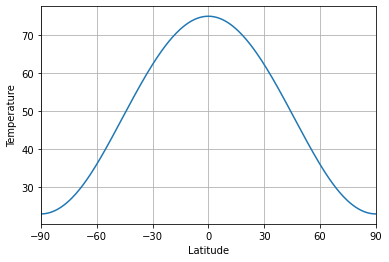

In [82]:
#Plot surface temperature as a function of latitude
plt.plot(m4.lat,m4.Ts)
plt.xlim(-90,90); plt.ylabel('Temperature'); plt.xlabel('Latitude')
plt.grid(); plt.xticks(my_ticks);

Suddenly the climate looks very very different again! What is the global mean temperature?

In [83]:
#print(climlab.global_mean(m4.Ts))#in degC

A tiny increase in $S_0$ has led to a very drastic change in the climate.

Now we will complete the plot of ice edge versus solar constant.

In [84]:
#  define an array of 50 So values from 1400 to 1900 W/m2
S0array_snowballmelt = np.linspace(1400,1900,50)

#  initialize arrays to save ice line latitudes
icelat_snowballmelt = np.empty_like(S0array_snowballmelt)
icelat_snowballmelt_cooling = np.empty_like(S0array_snowballmelt)

In [85]:
#Continue warming m2...
for n in range(S0array_snowballmelt.size):
    m2.subprocess['insolation'].S0 = S0array_snowballmelt[n]
    m2.integrate_years(10, verbose=False)
    icelat_snowballmelt[n] = np.max(m2.icelat)

#Now cool m2...
for n in range(S0array_snowballmelt.size):
    m2.subprocess['insolation'].S0 = np.flipud(S0array_snowballmelt)[n]
    m2.integrate_years(10, verbose=False)
    icelat_snowballmelt_cooling[n] = np.max(m2.icelat)

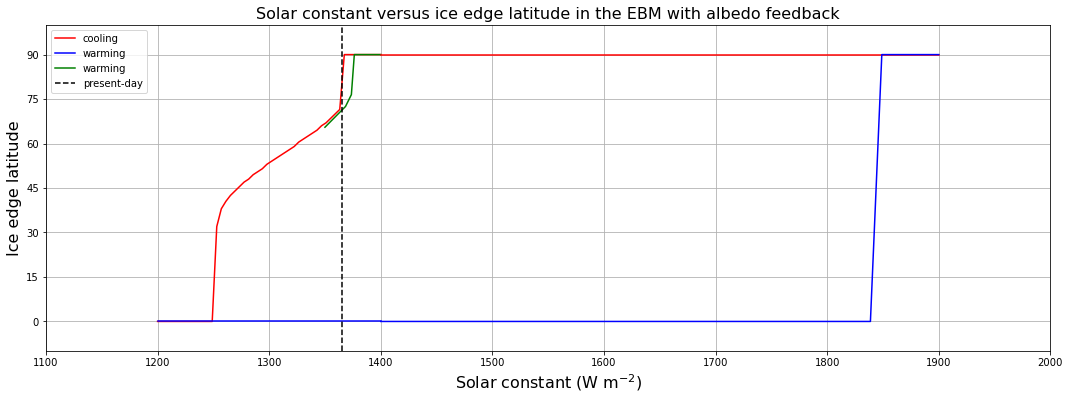

In [88]:
#  Plot the full hysteresis
fig = plt.figure( figsize=(18,6) )
ax = fig.add_subplot(111)
ax.plot(S0array, icelat_cooling, 'r-', label='cooling' )
ax.plot(S0array, icelat_warming, 'b-', label='warming' )
ax.plot(S0array3, icelat3, 'g-', label='warming' )

#  fill in the lines below to add new values to the plot out to So = 1900
ax.plot(S0array_snowballmelt,icelat_snowballmelt_cooling, 'r-' )
ax.plot(S0array_snowballmelt,icelat_snowballmelt, 'b-' )
ax.set_xlim(1100,2000)
ax.set_ylim(-10,100)
ax.set_yticks((0,15,30,45,60,75,90))
ax.grid()
ax.set_ylabel('Ice edge latitude', fontsize=16)
ax.set_xlabel('Solar constant (W m$^{-2}$)', fontsize=16)
ax.plot( [const.S0, const.S0], [-10, 100], 'k--', label='present-day' )
ax.legend(loc='upper left')
ax.set_title('Solar constant versus ice edge latitude in the EBM with albedo feedback', fontsize=16);
plt.savefig('Snowball_Earth_climlab.png')

This hysteresis model is a classic case study in climate science. Does it represent true tipping points in our climate system? Hard to say, but it demonstrates that tipping points are possible.

The take-aways:

- For extremely large $S_0$, the only possible climate is a hot Earth with no ice.
- For extremely small $S_0$, the only possible climate is a cold Earth completely covered in ice.
- For a large range of $S_0$ including the present-day value, more than one climate is possible!
- Once we get into a Snowball Earth state, getting out again is rather difficult!